In [1]:
def matmul_cpu(A, B):
    m, k = A.shape
    k, n = B.shape
    C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for l in range(k):
                C[i, j] += A[i, l] * B[l, j]
    return C


In [2]:
!pip install pycuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void matmul(float *A, float *B, float *C, int m, int k, int n) {
        int i = blockIdx.x * blockDim.x + threadIdx.x;
        int j = blockIdx.y * blockDim.y + threadIdx.y;
        if (i < m && j < n) {
            float sum = 0;
            for (int l = 0; l < k; l++) {
                sum += A[i * k + l] * B[l * n + j];
            }
            C[i * n + j] = sum;
        }
    }
""")

def matmul_gpu(A, B):
    m, k = A.shape
    k, n = B.shape
    C = np.zeros((m, n)).astype(np.float32)

    block_size = (32, 32,1)
    grid_size = ((m + block_size[0] - 1) // block_size[0], (n + block_size[1] - 1) // block_size[1])

    func = mod.get_function("matmul")
    func(cuda.In(A), cuda.In(B), cuda.Out(C), np.int32(m), np.int32(k), np.int32(n), block=block_size, grid=grid_size)

    return C


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=9cbd3823108ef6058e441285112d917df97b4796d341d252504bca2e588f3ba0
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69855 sha256=e9e23c683d0fb9e55423a964cd955e956bfee5295fd0d904a42f28f3257a795e
  Stored in directory: /root/.cache/pip/wheels/19/02

In [15]:
import numpy as np
import time

# Generate random matrices
A = np.random.rand(300,300).astype(np.float32)
B = np.random.rand(300,300).astype(np.float32)

# Time CPU-only implementation
start_time = time.time()
C_cpu = matmul_cpu(A, B)
end_time = time.time()
cpu_time = end_time - start_time
print("CPU time: {:.3f} s".format(end_time - start_time))

# Time PyCUDA-accelerated implementation
start_time = time.time()
C_gpu = matmul_gpu(A, B)
end_time = time.time()
gpu_time = end_time - start_time
print("GPU time: {:.3f} s".format(end_time - start_time))

# Check that results are the same
assert np.allclose(C_cpu, C_gpu)


CPU time: 18.514 s
GPU time: 0.004 s


CPU time: 19.892 s
GPU time: 0.003 s


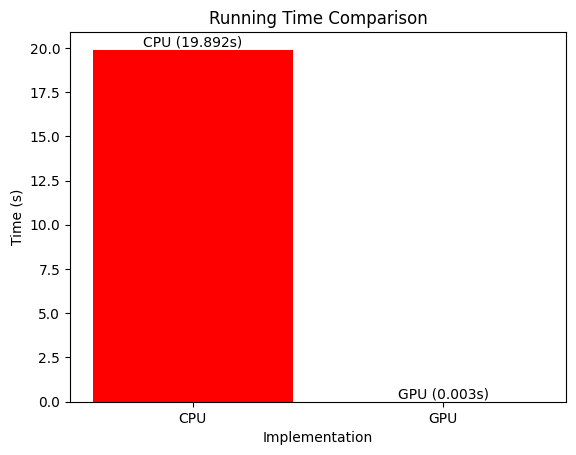

Time Difference: 19.889 s


In [16]:
import matplotlib.pyplot as plt

# ...

# Time CPU-only implementation
start_time = time.time()
C_cpu = matmul_cpu(A, B)
end_time = time.time()
cpu_time = end_time - start_time
print("CPU time: {:.3f} s".format(cpu_time))

# Time PyCUDA-accelerated implementation
start_time = time.time()
C_gpu = matmul_gpu(A, B)
end_time = time.time()
gpu_time = end_time - start_time
print("GPU time: {:.3f} s".format(gpu_time))

# Calculate the time difference
time_diff = cpu_time - gpu_time

# Plot the time difference
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
colors = ['red', 'green']
plt.bar(labels, times, color=colors)
plt.xlabel('Implementation')
plt.ylabel('Time (s)')
plt.title('Running Time Comparison')

# Add time labels to the plot
for i in range(len(labels)):
    plt.text(i, times[i], '{} ({:.3f}s)'.format(labels[i], times[i]), ha='center', va='bottom')

plt.show()

# Print the time difference
print("Time Difference: {:.3f} s".format(time_diff))
